In [1]:
!nvidia-smi

Fri Sep 15 09:17:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/anilbhatt1/ERA1_S17_BERT_GPT_VIT.git

Cloning into 'ERA1_S17_BERT_GPT_VIT'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 64 (delta 22), reused 53 (delta 11), pack-reused 0
Receiving objects: 100% (64/64), 4.47 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [3]:
import os
print(os.getcwd())
os.chdir('/content/ERA1_S17_BERT_GPT_VIT/assignment')
print(os.getcwd())

/content
/content/ERA1_S17_BERT_GPT_VIT/assignment


In [4]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00


In [9]:
import matplotlib.pyplot as plt
import torch
import torchvision
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torchvision import transforms
from torchinfo import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
import yaml
from transformer import *
from vit_utils import *
from engine import *
from predictions import *
from data_setup import *

cuda


In [8]:
os.cpu_count()

2

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
!cp "/content/gdrive/My Drive/EVA8_S11_Course_Docs/pizza_steak_sushi.zip" "/content"
!unzip -q '/content/pizza_steak_sushi.zip' -d '/content'

In [15]:
# Load the YAML file
with open('/content/ERA1_S17_BERT_GPT_VIT/assignment/config.yaml', 'r') as yaml_file:
    cfg = yaml.load(yaml_file, Loader=yaml.FullLoader)
cfg['model'] = 'vit'
model_nm = cfg['model']
print(model_nm)
cfg

vit


{'model': 'vit',
 'bert': {'batch_size': 1024,
  'seq_len': 20,
  'embed_size': 128,
  'inner_ff_size': 512,
  'n_heads': 8,
  'n_code': 8,
  'n_vocab': 40000,
  'dropout': 0.1,
  'n_workers': 12,
  'optim_kwargs': {'lr': 0.0001,
   'weight_decay': 0.0001,
   'betas': [0.9, 0.999]},
  'sentence_path': '/content/ERA1_S17_BERT_GPT_VIT/course_docs/BERT/training.txt',
  'vocab_path': '/content/ERA1_S17_BERT_GPT_VIT/course_docs/BERT/vocab.txt',
  'data_kwargs': {'shuffle': True,
   'drop_last': False,
   'pin_memory': True,
   'batch_size': 1024},
  'train_iter': 2000,
  'print_iter': 10,
  'embed_save_limit': 3000},
 'gpt': {'batch_size': 32,
  'block_size': 64,
  'dropout': 0.2,
  'lr': 0.0003,
  'num_embed': 768,
  'num_head': 6,
  'num_layer': 6,
  'max_iter': 1000,
  'eval_inter': 200,
  'data_path': '/content/ERA1_S17_BERT_GPT_VIT/course_docs/GPT/data/english.txt',
  'inference_tokens': 50},
 'vit': {'image_path': '/content/pizza_steak_sushi',
  'batch_size': 32,
  'img_size': 224,
  

In [16]:
print('initializing from config data..')
image_path = cfg[model_nm]['image_path']
batch_size = cfg[model_nm]['batch_size']
img_size = cfg[model_nm]['img_size']
patch_size = cfg[model_nm]['patch_size']
num_transformer_layers = cfg[model_nm]['num_transformer_layers']
embedding_dim = cfg[model_nm]['embedding_dim']
mlp_size = cfg[model_nm]['mlp_size']
num_heads = cfg[model_nm]['num_heads']
attn_dropout = cfg[model_nm]['attn_dropout']
mlp_dropout = cfg[model_nm]['mlp_dropout']
embedding_dropout = cfg[model_nm]['embedding_dropout']
num_classes = cfg[model_nm]['num_classes']

initializing from config data..


In [17]:
train_dir = image_path + "/train"
test_dir = image_path + "/test"

In [18]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = img_size

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [19]:
# Set the batch size
BATCH_SIZE = batch_size # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f84b7b66770>,
 ['pizza', 'steak', 'sushi'])

In [20]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

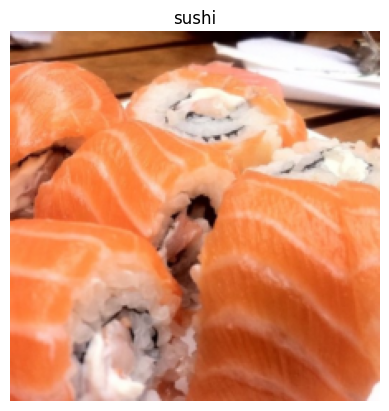

In [21]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [22]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(img_size=img_size,
          in_channels=3,
          patch_size=patch_size,
          num_transformer_layers=num_transformer_layers,
          embedding_dim=embedding_dim,
          mlp_size=mlp_size,
          num_heads=num_heads,
          attn_dropout=attn_dropout,
          mlp_dropout=mlp_dropout,
          embedding_dropout=embedding_dropout,
          num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2255,  0.0755,  0.4863]], grad_fn=<AddmmBackward0>)

In [23]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─vit_PatchEmbedding (patch_embedding)                       [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─vit_TransformerEncoderBlock (0)                       [32, 197, 768]       [32, 197, 768]

In [24]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3961 | train_acc: 0.4219 | test_loss: 4.1377 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.8009 | train_acc: 0.2656 | test_loss: 1.2018 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.3500 | train_acc: 0.3398 | test_loss: 1.2374 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2095 | train_acc: 0.2812 | test_loss: 1.0323 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1480 | train_acc: 0.2578 | test_loss: 1.0181 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1615 | train_acc: 0.2891 | test_loss: 1.0266 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1414 | train_acc: 0.2305 | test_loss: 1.2468 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2183 | train_acc: 0.2812 | test_loss: 1.0089 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2806 | train_acc: 0.2812 | test_loss: 1.1507 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.0961 | train_acc: 0.4258 | test_loss: 1.0152 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.1792 | train_acc: 0.2930 | test_loss: 1.2706 | test_acc: 0.1979
Epoch: 12 | train_l

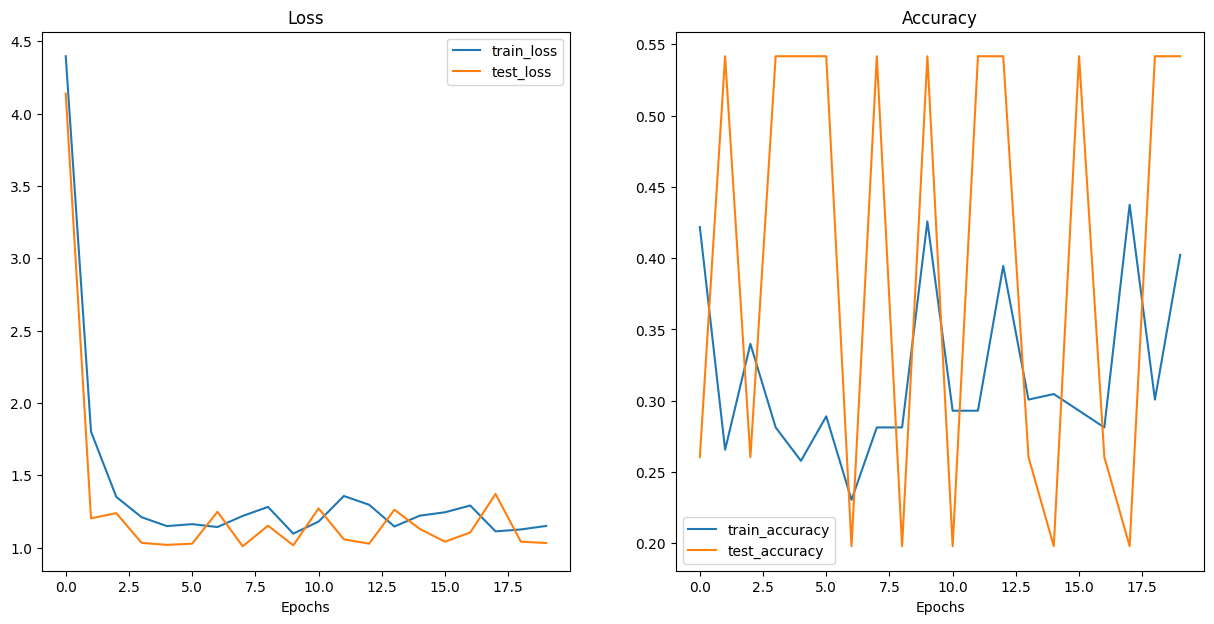

In [25]:
# Plot our ViT model's loss curves
plot_loss_curves(results)

In [26]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 119MB/s] 


In [27]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [28]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [30]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [32]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8020 | train_acc: 0.6953 | test_loss: 0.5058 | test_acc: 0.8580
Epoch: 2 | train_loss: 0.4019 | train_acc: 0.9375 | test_loss: 0.3448 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9648 | test_loss: 0.2288 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.1765 | train_acc: 0.9648 | test_loss: 0.2012 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1328 | train_acc: 0.9688 | test_loss: 0.2098 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.1169 | train_acc: 0.9805 | test_loss: 0.2219 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.1065 | train_acc: 0.9844 | test_loss: 0.2284 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.0923 | train_acc: 0.9844 | test_loss: 0.2180 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0830 | train_acc: 0.9844 | test_loss: 0.2011 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0768 | train_acc: 0.9883 | test_loss: 0.2009 | test_acc: 0.9384
Epoch: 11 | train_loss: 0.0809 | train_acc: 0.9883 | test_loss: 0.1999 | test_acc: 0.9384
Epoch: 12 | train_l

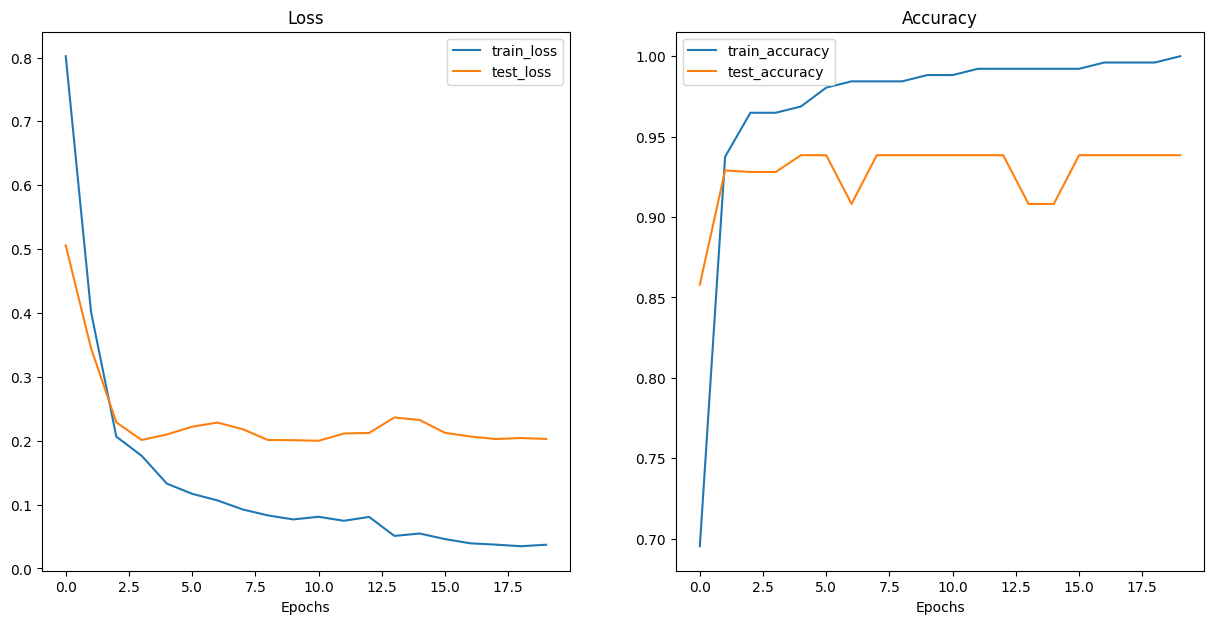

In [33]:
plot_loss_curves(pretrained_vit_results)

In [34]:
# Save the model
save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [35]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [41]:
def pred_and_plot_image_new(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

Downloading...


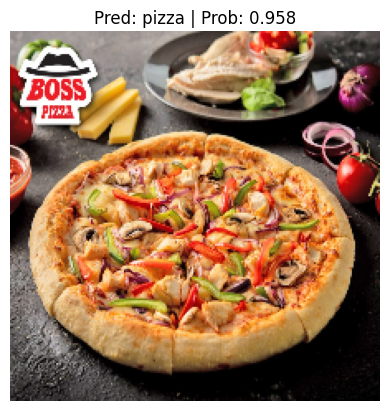

In [43]:
import requests

with open("download_new.jpeg", "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://www.boss-pizza.co.uk/site/assets/images/uploads/2_3_5c232a9d83be_o.jpg")
    print(f"Downloading...")
    f.write(request.content)

# Predict on custom image
pred_and_plot_image_new(model=pretrained_vit,
                    image_path="download_new.jpeg",
                    transform=transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    class_names=class_names)